#Transfer Learning(BERT를 중심으로)

###Transfer Learning(임베딩 벡터)

전이 학습이란 특정 분야에서 사전에 훈련된 신경망(Pre-trained model)을 그와 연관된 분야에서 사용되는 신경망의 학습에 이용하는 것을 말한다. 

초기의 NLP에서의 전이학습은 사전 훈련된 단어 임베딩 벡터(Word2Vec, FastText 등)를 사용해 모델을 개선하는 방식이 주였다. 이 벡터들의 가중치를 이용하는데는 크게 두 가지 방법이 있는데, 초깃값으로 사용하거나 아예 고정값으로 사용하는 것이다. 보통은 사전 학습된 모델의 파라미터를 초깃값으로 받아 천천히 학습하는데, 이때는 learning rate에 대한 하이퍼파라미터를 추가해야 합니다.

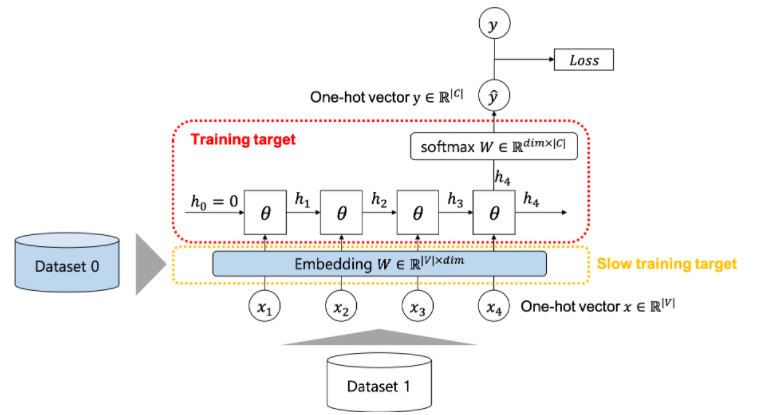

In [ ]:
optimizer = optim.Adam(model.softmax_layer.parameters() + model.rnn.parameters())
optimizer_emb = optim.Adam(model.emb_layer.parameters(), lr=1e-6)

하지만 이러한 임베딩 벡터는 하나의 단어를 하나의 벡터값으로 맵핑하므로 문맥을 잘 고려치 못한다는 한계가 존재합니다. 따라서 Dataset0에서 문장에 함께 출현한 단어들 사이의 의미 관계에 관한 정보만을 포함하므로 그 효율이 떨어집니다. 

###Transfer Learning(언어 모델)

이러한 한계를 극복하기 위해 NLP의 전이 학습은 언어의 기초적인 태스크(다음 단어 예측)를 학습한 사전 모델을 방대한 데이터로 학습시킨 후에, 보다 복잡한 태스크(분류, 번역)를 수행하는 모델에 접합시키는 방향으로 발전했습니다.

이때 사전 학습된 모델은 학습데이터로 병렬 코퍼스나 레이블링 텍스트가 아니라, 일반적인 문장들을 마스킹하여 사용하기 때문에 그 양과 비용에 있어서 큰 장점을 가집니다.

####BERT(Bidirectional Encoder Representations from Transforemr)

BERT는 트랜스포머를 이용한 사전 훈련 언어모델입니다. 일반적인 코퍼스를 이용한 방대한 훈련 데이터로 학습한 BERT를, 다른 태스크에서 추가 훈련과 하이퍼파라미터 조정 과정을 거쳐 해당 태스크에 대한 성능을 높입니다. 위 과정을 파인튜닝(Fine-tuning)이라 합니다.

BERT의 기본 구조는 트랜스포머의 인코더를 쌓아올린 형태입니다. Base 버전은 총 12개, Large 버전에는 총 24개의 트랜스포머 인코더를 쌓았습니다. 각 버전은 그 크기에 맞는 d_model과 셀프 에텐션 헤드를 가지고 있습니다.

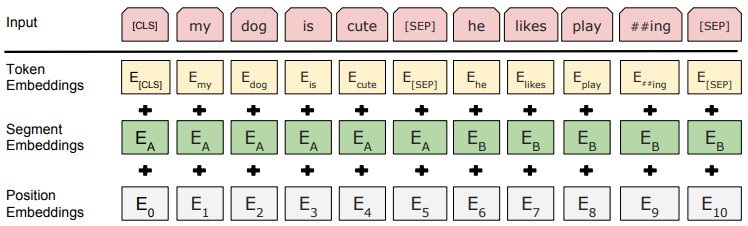

BERT의 입력단은 위와 같은 내부 구조를 가지고 있습니다. 훈련 데이터는 Token Embedding, Segment Embedding, Position Embedding으로 총 3개 층의 임베딩을 거칩니다.

Token Embedding은 기본적으로 WordPiece 토크나이저를 사용합니다. WordePiece는 각 Char단위로 임베딩을 하는 서브워드 토크나이저입니다. 등장 빈도가 높은 단어를 사전에 추가하고, 자주 등장하지 않는 단어는 서브워드로 분리시켜 사전에 추가합니다. 이 과정에서 등장 빈도가 낮은 단어들을 모두 'OOV'로 처리해 서능을 저하했던 문제를 해결합니다.

Segment Embedding은 두 개의 문장이 입력되는 경우에 각 문장을 구분하는 별도의 임베딩 층입니다. BERT는 두개 문장을 구분자([SEP])를 삽입해 분리하고, 문장 순서대로 Sentence0, Sentence1 ***으로 임베딩하는 방식입니다. 위 과정은 뒤의 NSP 훈련 방식에 필요합니다. 

Position Embedding은 트랜스포머의 셀프 어텐션 모델이 토큰 위치의 정보만을 고려하므로 이를 위해 입력 데이터의 순서대로 토큰에 라벨링을 해준다.

####Pre-Training

위와 같이 훈련 데이터를 모두 인코딩 하면, 사전 훈련을 진행합니다. 기존의 방법들은 보통 문장의 다음 단어를 예측하거나 중간 단어를 예측하는 방식을 사용했습니다. 하지만 BERT는 언어 특성을 잘 학습하도록, MLM(Masked Language Model)나 NSP(Next Sentence Prediction) 두 방식을 사용합니다.

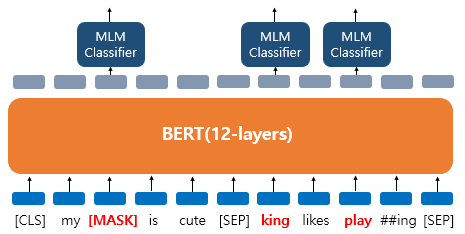

MLM은 입력 데이터의 15% 토큰들을 랜덤으로 마스킹 한 후, 그 단어들을 예측하도록 하는 훈련 방식입니다. 15%의 마스킹 중, 80%는 단순히 마스킹 후 예측하는 방식으로 나머지 각 10%는 단어의 교체 여부를 맞히거나 교체되기 전의 단어를 예측하는 방식으로 진행합니다.

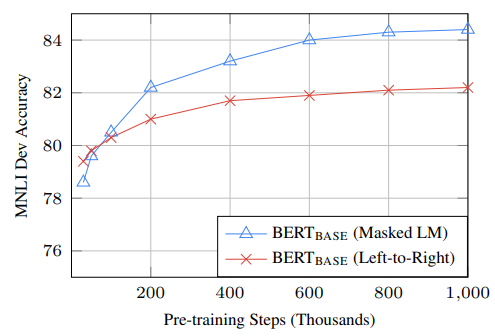

LTR과 달리 각각의 배치에 15%만을 학습에 이용하기 때문에 학습 속도는 조금 느리지만, 그 성능이 더욱 높다는 것을 확인할 수 있습니다. 

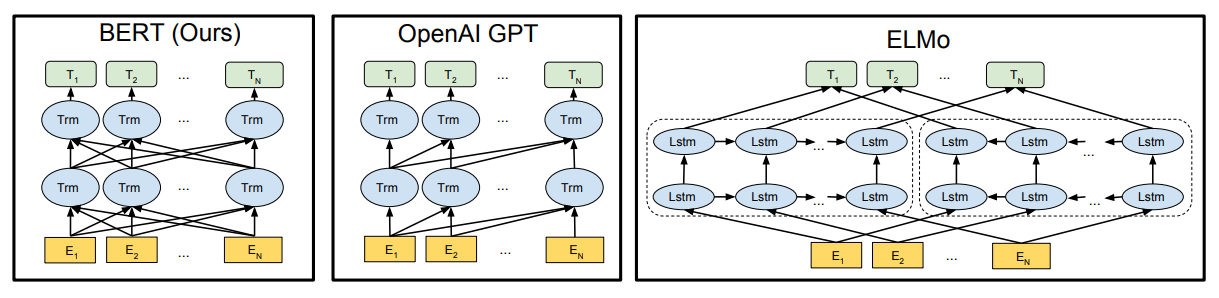

MLM이라는 훈련 방식을 통해 위와 같은 양방향성을 얻었기 때문이라고 해석하고 있습니다.

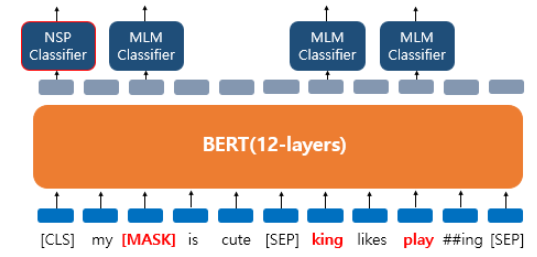

NSP는 두 문장이 주어졌을 때, 선후 관계를 예측하는 훈련입니다. 두 문장이 연결된 문장인지 아닌지를 판단하는 이진분류로 학습을 진행합니다. 병렬 코퍼스를 훈련 데이터로 받는(NLI 혹은 QA)모델에서의 파인 튜닝을 위해 진행합니다.

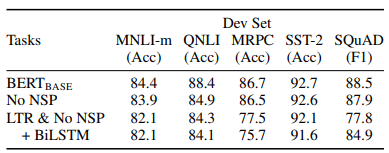

위는 각 훈련 방식과 태스크에 따른 성능입니다. QNLI의 성능차이에서 NSP의 필요성을 확인할 수 있습니다.